In [1]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import tensorflow.keras.applications.vgg19 as vgg19

style_path = 'training_data.jpg'
content_path = 'test_data.jpg'

tf.enable_eager_execution()

In [2]:
plt.figure(figsize=(10,10))

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [3]:
content_layers = ['block5_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']


num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [4]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

In [5]:
def preprocess_image(image):
    max_dim = 512
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    shape = tf.cast(tf.shape(image)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    
    new_shape = tf.cast(shape * scale, tf.int32)
    
    image = tf.image.resize_images(image, new_shape)
    image = image[tf.newaxis, :]
    return image

In [6]:
style_image = load_and_preprocess_image(style_path)
content_image = load_and_preprocess_image(content_path)

In [7]:
from tensorflow.keras.models import Model

def create_model(layer_names): 
    vgg = vgg19.VGG19(include_top=True, weights='imagenet')
    vgg.trainable = False
    
    outputs = [vgg.get_layer(name).output for name in layer_names]
    
    model = Model([vgg.input], outputs)
    
    return model

In [8]:
def create_gram_matrix(input_tensor):
    # lets denote input_tensor[0] as b, [1] as i, [2] as j, and [3] as c = d
    # einsum to square input_tensor[0][1][2] then sum by [1][2] and display [0][3][3]
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    #cast 2 ints to float
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    
    return result/(num_locations)

In [9]:
def init_model(style_layers, content_layers):
    model = create_model(style_layers + content_layers)
    return model, style_layers, content_layers, len(style_layers)

In [10]:
def call_model(config, inputs):
    model, style_layers, content_layers, num_style_layers = config
    inputs = inputs * 255.0
    preprocessed_input = vgg19.preprocess_input(inputs)
    model_outputs = model(preprocessed_input)
    
    style_outputs, content_outputs = (model_outputs[:num_style_layers], 
                                      model_outputs[num_style_layers:])
    style_outputs = [create_gram_matrix(style_output)
                     for style_output in style_outputs]
    
    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}


In [11]:
config = init_model(style_layers, content_layers)

In [12]:
style_targets = call_model(config, style_image)['style']
content_targets = call_model(config, content_image)['content']

image = tf.Variable(content_image)

def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

opt = tf.train.AdamOptimizer(learning_rate=0.02, beta1=0.99, epsilon=1e-1)

style_weight=1e-2
content_weight=1e4

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]

  return x_var, y_var

def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_mean(x_deltas**2) + tf.reduce_mean(y_deltas**2)


In [13]:
def train_step(image):
    total_variation_weight=1e8
    with tf.GradientTape() as tape:
        outputs = call_model(config, image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight*total_variation_loss(image)
    
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

In [14]:
def transform_image(image, epochs = 10, steps_per_epoch = 100):
    step = 0
    for n in range(epochs * steps_per_epoch):
        step += 1
        train_step(image)
        if step % 10 == 0:
            print(step)
        if step % steps_per_epoch == 0:
            plt.imshow(image.read_value()[0])
            plt.title("Train step: {}".format(step))
            plt.show()


10
20
30
40
50
60
70
80
90
100


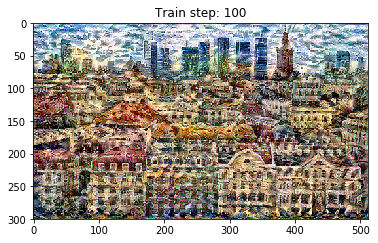

110
120
130
140
150
160
170
180
190
200


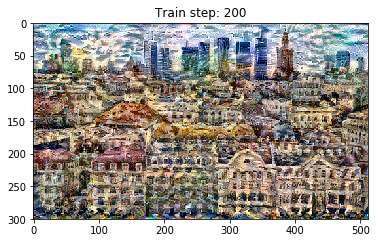

210
220
230
240
250
260
270
280
290
300


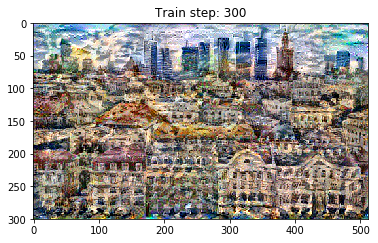

310
320
330
340
350
360
370
380
390
400


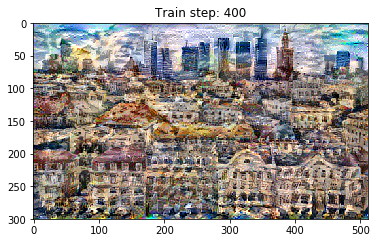

410
420
430
440
450
460
470
480
490
500


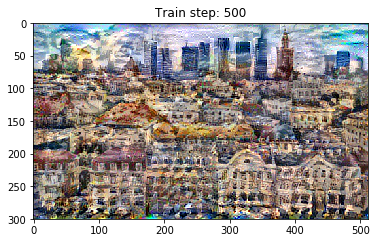

510
520
530
540
550
560
570
580
590


In [ ]:
transform_image(image)